In [1]:
import numpy as np
from floquet_simulations.plot_functions import PlotParams

PlotParams(fontsize=10)
from floquet_simulations.hamiltonians import GetEvalsAndEvecsGen

from scipy.integrate import solve_ivp
from floquet_simulations.hamiltonians import RoundComplex

from floquet_simulations.plot_functions import PlotAbsRealImagHamiltonian
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.special import jv
from pathlib import Path
import pandas as pd
import math
from numpy import sin, pi



def square_2D_edges(rows, columns):
    H0 = np.zeros((rows*columns,rows*columns))
    # 
    links = []
    for y in range(rows):
        for x in range(columns-1):
            links.append((x + y*columns, x+1 + y* columns))
    for y in range(rows-1):
        for x in range(columns):
            links.append((x + columns*y, x+columns + columns*y))
    return(links)



def H0_2D(rows, columns):
    H0 = np.zeros((rows*columns,rows*columns))
    links = square_2D_edges(rows, columns)
    for link in links:
        H0[link[0], link[1]] = -1
        H0[link[1], link[0]] = -1
    return H0



def HT(H0, funcs, sites, t):

    for func, site in zip(funcs, sites):
        H0[site-1,site-1] = func(t)
    return H0



def FT(t, psi, H0, funcs, sites):
    H = HT(H0, funcs, sites, t)
    return -1j*np.dot(H, psi)



def SolveSchrodinger(H0, funcs, sites, tspan, n_timesteps, psi0):
    
    rtol=1e-11
    # points to calculate the matter wave at
    t_eval = np.linspace(tspan[0], tspan[1], n_timesteps+1, endpoint=True)
    sol = solve_ivp(lambda t,psi: FT(t, psi, H0, funcs, sites), 
            t_span=tspan, y0=psi0, rtol=rtol, 
            atol=rtol, t_eval=t_eval,
            method='RK45')
    sol=sol.y
    return sol



def CreateHF(H0, funcs, sites, T, num_sites, t0=0, hermitian_accuracy_dp=7): 
    """
    t0 is fraction of T
    """

    #sanity check
    assert(len(H0) == num_sites)
    
    tspan = (t0*T,T+t0*T)
    UT = np.zeros([num_sites, num_sites], dtype=np.complex_)
    n_timesteps = 100
    
    for A_site_start in range(num_sites):
        psi0 = np.zeros(num_sites, dtype=np.complex_); psi0[A_site_start] = 1
        sol = SolveSchrodinger(H0, funcs, sites, tspan, n_timesteps, psi0)
        UT[:,A_site_start]=sol[:,-1] 
    
    # evals_U, evecs = eig(UT)
    evals_U, evecs = GetEvalsAndEvecsGen(UT) #evals can be imaginary
    evals_H = 1j / T *np.log(evals_U)
    
    HF = np.zeros([num_sites,num_sites], dtype=np.complex_)
    for i in range(num_sites):
        term = evals_H[i]*np.outer(evecs[:,i], np.conj(evecs[:,i]))
        HF = HF+term

    HF = RoundComplex(HF, hermitian_accuracy_dp)
    # assert(np.all(0 == (HFr - np.conj(HFr.T))))
    return UT, HF
    # if np.all(0 == (HF - np.conj(HF.T))):
    #     return UT, HF
    # else:
    #     return np.nan, np.nan



def get_A_and_xi_ij(Ai, Aj, phii, phij):
# note we expect  Aj term to be negative ie we are finding the difference between Ai cos(omega t + phii) - Aj cos (omega t + phij)!!!!!
# calculates the the difference, not the sum
    if (np.round(Ai,7) ==np.round(Aj,7)) and ((np.round(phii/pi,7) == np.round(phij/pi,7)) or (np.round(phii/pi,7)== np.round( phij/pi + 2,7)) or (np.round(phii/pi + 2,7)== np.round( phij/pi,7))):
        return 0,0
    # elif (np.round(Ai,7) ==np.round(Aj,7)):
    #     return 2*Ai*sin((phij - phii)/2), (phii + phij + pi)/2
    else:
        Aij =  np.sqrt(Aj**2 + Ai**2 - 2*Ai*Aj*np.cos(phii - phij))

        cos_result = (-Aj * np.cos(phij) + Ai*np.cos(phii))/(Aij)
        sin_result = (-Aj*np.sin(phij) + Ai*np.sin(phii))/(Aij)
        cos_args = np.round(np.array( [np.arccos(cos_result)/np.pi, 2 - np.arccos(cos_result)/np.pi])  , 5)
        sin_args = np.round(np.array([i + 2 if i<0 else i for i in [np.arcsin(sin_result)/np.pi, 1 - np.arcsin(sin_result)/np.pi] ]), 5)

        return Aij, np.intersect1d(cos_args, sin_args)[0]*np.pi
    

    
def Vt(m,n, kappa, omega, t):
    phi0 = 0
    fr = np.cos(m*np.pi/2 - np.pi/4)
    fb = np.cos(m*np.pi/2 + np.pi/4)
    gr = phi0 - n*np.pi/2
    gb = n*np.pi/2 - phi0 - np.pi/2
    return kappa*(fr*np.cos(omega*t + gr) + fb*np.cos(omega*t + gb)) #+ Delta/2*(-1)**m + delta/2*((-1)**m + (-1)**n)


In [2]:
omega = 25
Delta = omega
kappa = 20

L_x = 4
L_y = 4
N = L_x*L_y
plaquette_sides =  [(0,0), (L_x,1), (L_x - 1, L_x + 1), (-1,L_x)]
plaquettess = [[(kk+1+i, kk+j) for (i,j) in plaquette_sides] for kk in np.array([[jj*L_x+ ii for ii in range(L_x-1)] for jj in range(L_y - 1)]).flatten()]


T = 2*np.pi/omega
m_site, n_site = np.meshgrid(np.arange(L_x), np.arange(L_y))

# get As and offsets from aidelsburger paper
site_drives_and_offsets = np.array([[get_A_and_xi_ij(kappa*np.cos(m_it*np.pi/2 - np.pi/4),-kappa*np.cos(m_it*np.pi/2 + np.pi/4), - n_it*np.pi/2, n_it*np.pi/2  - np.pi/2) for m_it in range(L_x)] for n_it in range(L_y)])
#turns out as are the same as kappa
A_j = site_drives_and_offsets[:,:,0]
print(A_j.T)
#varphis are this weird thing
varphi_j = site_drives_and_offsets[:,:,1]
print(varphi_j.T/np.pi)

nus = (np.array([0,1]*int(L_x/2)*L_y)*omega).reshape(L_y, L_x)
print(nus.T)

[[20. 20. 20. 20.]
 [20. 20. 20. 20.]
 [20. 20. 20. 20.]
 [20. 20. 20. 20.]]
[[1.75 1.75 0.75 0.75]
 [0.25 1.25 1.25 0.25]
 [0.75 0.75 1.75 1.75]
 [1.25 0.25 0.25 1.25]]
[[ 0  0  0  0]
 [25 25 25 25]
 [ 0  0  0  0]
 [25 25 25 25]]


In [39]:


# dphiz = [pi*0,
#          pi*0.24,
#          pi*0,
#          pi*0,
#          ]


# rel_mod_row1to2= np.array([[get_A_and_xi_ij(A_j[row,col+1],A_j[row,col],varphi_j[row,col+1],varphi_j[row,col]) for col in range(L_x - 1)] for row in range(L_y)] )
# A_ij = rel_mod_row1to2[:,:,0]
# xi_ij = rel_mod_row1to2[:,:,1]
# # print(A_ij)
# print(xi_ij/np.pi)


In [60]:
#Just HF from aidelsburger drive
sites = np.arange(1,L_x*L_y + 1,1)
## get drives on each site
funcs2 = [lambda t, A=A, varphi=varphi, nu=nu: A*np.cos(omega*t + varphi) + nu for (A, varphi, nu) in zip(A_j.flatten(), varphi_j.flatten(), nus.flatten())]
_, HF2 = CreateHF(H0_2D(L_y,L_x), funcs2, sites, T, num_sites=L_x*L_y, t0=0, hermitian_accuracy_dp=7)

with pd.option_context('display.max_rows', None,
                    'display.max_columns', 10,
                    'display.precision', 2,
                    ):
#         print(tunnellings_abs)
        print(pd.DataFrame(np.array([np.angle(math.prod([HF2[i, j] for (i,j) in plaquette]))/np.pi for plaquette in plaquettess]).reshape((L_x - 1,L_y - 1))))

## second drive from row 2onwards
# additional_drive_A = np.array([[0] +[2*A_ij[row,0]*sin(dphiz[row]/2)]*(L_x - 1) for row in range(L_y)])
# additional_drive_varphi = np.array([[0] + [-xi_ij[row,0] + dphiz[row]/2]*(L_x - 1) for row in range(L_y)])
# funcs4 = [lambda t, A=A, varphi=varphi, nu=nu, A_addit=A_addit, varphi_addit=varphi_addit: A*np.cos(omega*t + varphi) 
#           + A_addit*sin(omega*t - varphi_addit)+ nu for (A, varphi, nu, A_addit, varphi_addit) in zip(A_j.flatten(), varphi_j.flatten(), nus, additional_drive_A.flatten(), additional_drive_varphi.flatten())]
# _, HF4 = CreateHF(H0_2D(L_y,L_x), funcs4, sites, T, num_sites=L_x*L_y, t0=0, hermitian_accuracy_dp=7)

A_j = A_j.flatten()
varphi_j = varphi_j.flatten()
nus = nus.flatten()
# for links 1-10
Bs = np.zeros((N, N))
xis = np.zeros((N, N))
HF_theory = np.zeros((N, N), dtype=np.complex128)
#do horizontal links
for ny in range(L_y):
        for nx in range(L_x-1):        
                jj = nx + L_x*ny
                ii = nx+L_x*ny + 1

                nu_ij = int(nus[ii] - nus[jj])/omega
                
                B_ij, xi_ij= get_A_and_xi_ij(A_j[ii], A_j[jj], varphi_j[ii], varphi_j[jj])
                t_ij = (float(-1))**nu_ij*jv(nu_ij, B_ij/omega)*np.exp((-1)*nu_ij*1j*xi_ij)

                Bs[ii, jj] = B_ij
                xis[ii, jj] = xi_ij

                HF_theory[ii,jj] = t_ij
                HF_theory[jj, ii] = np.conj(t_ij)

        #do vertical links
for ny in range(L_y-1):
        for nx in range(L_x):
                jj = nx + L_x*ny
                ii = nx+L_x*ny + L_x

                B_ij, xi_ij= get_A_and_xi_ij(A_j[ii], A_j[jj], varphi_j[ii], varphi_j[jj])
                t_ij = jv(0, B_ij/omega)

                Bs[ii,jj] = B_ij
                xis[ii, jj] = xi_ij
                HF_theory[ii,jj] = t_ij
                HF_theory[jj, ii] = np.conj(t_ij)
                            


with pd.option_context('display.max_rows', None,
                    'display.max_columns', 10,
                    'display.precision', 2,
                    ):
#         print(tunnellings_abs)
        print(pd.DataFrame(np.array([np.angle(math.prod([HF_theory[i, j] for (i,j) in plaquette]))/np.pi for plaquette in plaquettess]).reshape((L_x - 1,L_y - 1))))


     0    1    2
0  0.5  0.5  0.5
1  0.5  0.5  0.5
2  0.5  0.5  0.5
     0    1    2
0  0.5  0.5  0.5
1  0.5  0.5  0.5
2  0.5  0.5  0.5


### calculate mag field gradient

## calculate which fluxes are where

In [82]:
# x_tunnel_indices = np.array([[jj*L_x+ ii for ii in range(L_x)] for jj in range(L_y - 1)]).flatten()
# print([f"{HF_theory[i,i+L_x]:.3f}" for i in x_tunnel_indices])
nx = 0
ny = 0
# vertical link in .T picture
jj = nx + L_x*ny
ii = nx+L_x*ny + L_x
print(f"horiz: {HF_theory[ii,jj]:.2f}")
#horizontal links
jj = nx + L_x*ny
ii = nx+L_x*ny + 1
print(f"vert: {HF_theory[ii,jj]:.2f}")


horiz: 1.00+0.00j
vert: -0.00+0.48j


In [78]:
np.sin(pi/4)**2


0.4999999999999999

In [49]:

def make_bewteen_0_2(x):
    if x <0:
        return x+2
    elif x > 2:
        return x - 2
    else:
        return x
    
def get_xi_same_a(A, varphii, varphij):
    Aij = A*np.abs(2*sin((varphij - varphii)/2))
    if varphij > varphii:
        # ie Aij is naturally positive
        return Aij, (varphii + varphij)/2 -pi/2
    elif varphij < varphii:
        return Aij,  (varphii + varphij)/2 + pi/2
    else:
        return 0, 0
            
# results= []
varphii = 0.25#np.linspace(0, 2, 20)[0]
varphij =  1.75#np.linspace(0,2,20)[19]
A = 20
print(varphii, varphij)
aa, xi = get_A_and_xi_ij(A, A, varphii*pi, varphij*pi)

bb, xi2 = get_xi_same_a(A, varphii*pi, varphij*pi)
 
print([aa, bb, make_bewteen_0_2(xi/pi), make_bewteen_0_2(xi2/pi)])

0.25 1.75
[28.284271247461902, 28.284271247461902, 0.5, 0.5]


## Get sinusoidal functions on each site, according to aidelsburger paper

In [3]:

    # omega = 10
omega = 25
Delta = omega
kappa = 20

L_x = 6
L_y = 6
N = L_x*L_y

T = 2*np.pi/omega
m_site, n_site = np.meshgrid(np.arange(L_x), np.arange(L_y))

# get As and offsets from aidelsburger paper
site_drives_and_offsets = np.array([[get_A_and_xi_ij(kappa*np.cos(m_it*np.pi/2 - np.pi/4),-kappa*np.cos(m_it*np.pi/2 + np.pi/4), - n_it*np.pi/2, n_it*np.pi/2  - np.pi/2) for m_it in range(L_x)] for n_it in range(L_y)])
#turns out as are the same as kappa
A_j = site_drives_and_offsets[:,:,0]
print(A_j)
# varphis are this weird thing
varphi_j = site_drives_and_offsets[:,:,1]
print(varphi_j/np.pi)

nus = np.array([0,1]*int(L_x/2)*L_y)*omega

dphiz = [pi*0,
         pi*0,
         pi*0.5,
         pi*0.5,
         pi*0,
         pi*0
         ]


rel_mod_row1to2= np.array([[get_A_and_xi_ij(A_j[row,col+1],A_j[row,col],varphi_j[row,col+1],varphi_j[row,col]) for col in range(L_x - 1)] for row in range(L_y)] )
A_ij = rel_mod_row1to2[:,:,0]
xi_ij = rel_mod_row1to2[:,:,1]
# print(A_ij)
# print(xi_ij/np.pi)


# print(rel_mod_row1to2[:,1]/np.pi)
additional_drive_A = np.array([[0] +[2*A_ij[row,0]*sin(dphiz[row]/2)]*(L_x - 1) for row in range(L_y)])
additional_drive_varphi = np.array([[0] + [-xi_ij[row,0] + dphiz[row]/2]*(L_x - 1) for row in range(L_y)])



# print(additional_drive_A)
# varphis_original_coded = ( -1 +(-1)**(n_site%2)*m_site*2   + (n_site - n_site%2) *2) %8 *0.25*np.pi
# print(varphis_original_coded / np.pi /0.25)

# varphis_new_coded = ( -1/5 +(-1)**(n_site%2)*m_site*2   + (n_site - n_site%2) *2) %8 *0.25*np.pi
# print(varphis_new_coded / np.pi/0.25 )

sites = np.arange(1,L_x*L_y + 1,1)
# funcs = [lambda t, m=m, n=n, nu=nu: Vt(m, n, kappa, omega, t) + nu for (m, n, nu) in zip(m_site.flatten(), n_site.flatten(), nus)]
# _, HF = CreateHF(H0_2D(L_y,L_x), funcs, sites, T, num_sites=L_x*L_y, t0=0, hermitian_accuracy_dp=7)

## get drives on each site
funcs2 = [lambda t, A=A, varphi=varphi, nu=nu: A*np.cos(omega*t + varphi) + nu for (A, varphi, nu) in zip(A_j.flatten(), varphi_j.flatten(), nus)]
_, HF2 = CreateHF(H0_2D(L_y,L_x), funcs2, sites, T, num_sites=L_x*L_y, t0=0, hermitian_accuracy_dp=7)


## get drives on each sitewith manually encoded varphis
# funcs3 = [lambda t, A=A, varphi=varphi, nu=nu: A*np.cos(omega*t + varphi) + nu for (A, varphi, nu) in zip(A_j.flatten(), varphis_new_coded.flatten(), nus)]
# _, HF3 = CreateHF(H0_2D(L_y,L_x), funcs3, sites, T, num_sites=L_x*L_y, t0=0, hermitian_accuracy_dp=7)


## second drive from row 2onwards
funcs4 = [lambda t, A=A, varphi=varphi, nu=nu, A_addit=A_addit, varphi_addit=varphi_addit: A*np.cos(omega*t + varphi) 
          + A_addit*sin(omega*t - varphi_addit)+ nu for (A, varphi, nu, A_addit, varphi_addit) in zip(A_j.flatten(), varphi_j.flatten(), nus, additional_drive_A.flatten(), additional_drive_varphi.flatten())]
_, HF4 = CreateHF(H0_2D(L_y,L_x), funcs4, sites, T, num_sites=L_x*L_y, t0=0, hermitian_accuracy_dp=7)

A_j = A_j.flatten()
varphi_j = varphi_j.flatten()
# for links 1-10
Bs = np.zeros((N, N))
xis = np.zeros((N, N))
HF_theory = np.zeros((N, N), dtype=np.complex128)
#do horizontal links
for ny in range(L_y):
        for nx in range(L_x-1):        
                jj = nx + L_x*ny
                ii = nx+L_x*ny + 1

                nu_ij = int(nus[ii] - nus[jj])/omega
                
                B_ij, xi_ij= get_A_and_xi_ij(A_j[ii], A_j[jj], varphi_j[ii], varphi_j[jj])
                t_ij = (float(-1))**nu_ij*jv(nu_ij, B_ij/omega)*np.exp((-1)*nu_ij*1j*xi_ij)

                Bs[ii, jj] = B_ij
                xis[ii, jj] = xi_ij

                HF_theory[ii,jj] = t_ij
                HF_theory[jj, ii] = np.conj(t_ij)

        #do vertical links
for ny in range(L_y-1):
        for nx in range(L_x):
                jj = nx + L_x*ny
                ii = nx+L_x*ny + L_x

                B_ij, xi_ij= get_A_and_xi_ij(A_j[ii], A_j[jj], varphi_j[ii], varphi_j[jj])
                t_ij = jv(0, B_ij/omega)

                Bs[ii,jj] = B_ij
                xis[ii, jj] = xi_ij
                HF_theory[ii,jj] = t_ij
                HF_theory[jj, ii] = np.conj(t_ij)
        # 

tunnelling_indices = [(1,2), (2,3), (3,4), (1,5), (2,6), (3,7), (4,8), (5,6), (6,7), (7,8)
                      ,(9,10), (10,11),(11,12)
                #       ,(9,13),(10,14),(11,15),(12,16),(13,14),(14,15),(15,16)
                      ]
# exp_list = [-HF[i-1, j-1] for (i,j) in tunnelling_indices]
# exp2_list = [-HF2[i-1, j-1] for (i,j) in tunnelling_indices]
# theory_list =  [HF_theory[i-1, j-1] for (i,j) in tunnelling_indices]
tunnellings_abs = pd.DataFrame({"index": tunnelling_indices,
                            "theory_abs":np.abs(np.array([HF_theory[i-1, j-1] for (i,j) in tunnelling_indices])),
                        #     "exp1_abs":np.abs(np.array([-HF[i-1, j-1] for (i,j) in tunnelling_indices])),
                            "exp_abs":np.abs(np.array([-HF2[i-1, j-1] for (i,j) in tunnelling_indices])),
                            "exp4_abs":np.abs(np.array([-HF4[i-1, j-1] for (i,j) in tunnelling_indices]))})

tunnelling_angles = pd.DataFrame({"index": tunnelling_indices,
                                "theory_angle":np.angle(np.array( [HF_theory[i-1, j-1] for (i,j) in tunnelling_indices]))/np.pi,
                        #     "exp1_angle":np.angle(np.array( [-HF[i-1, j-1] for (i,j) in tunnelling_indices]))/np.pi,
                            "exp_angle":np.angle(np.array( [-HF2[i-1, j-1] for (i,j) in tunnelling_indices]))/np.pi,
                            "exp4_angle":np.angle(np.array( [-HF4[i-1, j-1] for (i,j) in tunnelling_indices]))/np.pi,
                            })
                            
plaquettess = [p1, p2, p3, p4, p5, p6, p7, p8, p9]
fluxes = pd.DataFrame({"theory":[np.angle(math.prod([HF_theory[i, j] for (i,j) in plaquette]))/np.pi for plaquette in plaquettess],
                        # "exp":   [np.angle(math.prod([HF[i, j] for (i,j) in plaquette]))/np.pi for plaquette in plaquettess],
                        "exp": [np.angle(math.prod([HF2[i, j] for (i,j) in plaquette]))/np.pi for plaquette in plaquettess],
                         "exp4":  [np.angle(math.prod([HF4[i, j] for (i,j) in plaquette]))/np.pi for plaquette in plaquettess] 
                             })


with pd.option_context('display.max_rows', None,
                    'display.max_columns', 10,
                    'display.precision', 2,
                    ):
#         print(tunnellings_abs)
        print(pd.DataFrame(np.array([np.angle(math.prod([HF4[i, j] for (i,j) in plaquette]))/np.pi for plaquette in plaquettess]).reshape((3,3))))


[[1.75 0.25 0.75 1.25 1.75 0.25]
 [1.75 1.25 0.75 0.25 1.75 1.25]
 [0.75 1.25 1.75 0.25 0.75 1.25]
 [0.75 0.25 1.75 1.25 0.75 0.25]
 [1.75 0.25 0.75 1.25 1.75 0.25]
 [1.75 1.25 0.75 0.25 1.75 1.25]]
          0     1     2
0 -5.74e-01 -0.61  0.83
1 -8.24e-01 -0.43 -0.21
2 -6.58e-03 -0.50  0.31


# plot HF

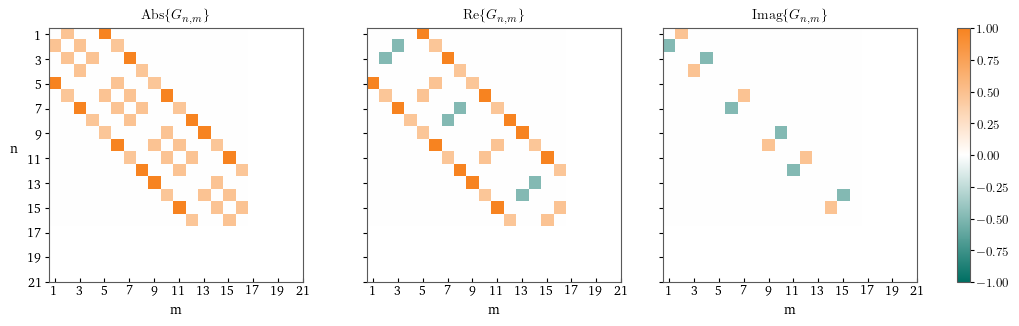

In [72]:

figsize = (25, 8)
colourbar_pad=0.4
colourbar_size_percentage=5
save_location = False
HF = HF_theory.T
absMax = np.max([np.abs(np.min(np.real(HF))),
                np.abs(np.max(np.real(HF))),
                np.abs(np.min(np.imag(HF))),
                np.abs(np.max(np.imag(HF)))])

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
# norm = mpl.colors.Normalize(vmin=-absMax, vmax=absMax)
# linthresh = 1e-1
# norm=mpl.colors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=-1.0, vmax=1.0, base=10)

'''abs real imag'''

apply = [
            np.abs, 
            np.real, np.imag]
labels = [
            r'$\mathrm{Abs}\{G_{n,m}\}$', 
            r'$\mathrm{Re}\{G_{n,m}\}$',
            r'$\mathrm{Imag}\{G_{n,m}\}$'
            ]

cmap = LinearSegmentedColormap.from_list('custom hamiltonians', ['#006F63', "#FFFFFF", '#F78320'], N=256)
cm_unit = 1/2.54
fig, ax = plt.subplots(nrows=1, ncols=len(apply), sharey=True, constrained_layout=True, 
                        figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

# fig.suptitle(rf"$\omega={omega}, A_1 ={A1}, A_2 = {A2}, A_3 = {A3}, A_4 = {A4}$")
for n1, f in enumerate(apply):
    pcm = ax[n1].matshow(f(HF), interpolation='none', cmap=cmap,  norm=norm)
    ax[n1].set_title(labels[n1])
    ax[n1].tick_params(axis="x", bottom=True, top=False, labelbottom=True, 
        labeltop=False)  
    ax[n1].set_xlabel('m')
    ax[n1].set_xticks(np.arange(0,21,2))
    ax[n1].set_xticklabels(np.arange(1,22,2))

ax[0].set_ylabel('n', rotation=0, labelpad=10)
ax[0].set_yticks(np.arange(0,21,2))
ax[0].set_yticklabels(np.arange(1,22,2))


divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size=f"{colourbar_size_percentage}%", pad=colourbar_pad)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)# label="unweighted graph distance")
# if save_location:
#     if save_location.as_posix().find("pdf"):
#         fig.savefig(save_location, format="pdf", bbox_inches="tight")
#     elif save_location.as_posix().find("png"):
#         fig.savefig(save_location, format="png", bbox_inches="tight")

plt.show()